In [39]:
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib as mpl
from matplotlib import colormaps

In [54]:
class FastF1Analysis:
    def __init__(self, year):
        self.year = year
        self.schedule = fastf1.get_event_schedule(year)
        self.session = None

    def load_session(self, event_name, session_type):
        self.session = fastf1.get_session(self.year, event_name, session_type)
        self.session.load()

    def sector_time_comparison(self):
        df = self.session.laps
        df = df[df['LapTime'].notnull()]
        fastest = df.groupby('Driver')[['Sector1Time', 'Sector2Time', 'Sector3Time']].min()
        fastest = fastest.apply(lambda x: x.dt.total_seconds())
        return fastest.sort_values(by='Sector1Time')

    def pit_stop_summary(self):
        df = self.session.laps
        pit_counts = df[df['PitInTime'].notna()].groupby('Driver')['PitInTime'].count()
        return pit_counts.sort_values()

    def tyre_compound_analysis(self):
        df = self.session.laps
        compound_usage = df.groupby(['Driver', 'Compound'])['LapNumber'].count().reset_index()
        compound_pivot = compound_usage.pivot(index='Driver', columns='Compound', values='LapNumber').fillna(0)
        return compound_pivot

    def driver_position_chart(self):
        df = self.session.laps
        df = df[df['Position'].notnull()]
        plt.figure(figsize=(12, 6))
        for driver in df['Driver'].unique():
            plt.plot(df[df['Driver'] == driver]['LapNumber'],
                     df[df['Driver'] == driver]['Position'],
                     label=driver)
        plt.gca().invert_yaxis()
        plt.xlabel("Lap")
        plt.ylabel("Position")
        plt.title(f"{self.session.event['EventName']} {self.year} - Position Changes")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def compare_speed_overlay(self, driver1, driver2):
        lap1 = self.session.laps.pick_drivers(driver1).pick_fastest()
        lap2 = self.session.laps.pick_drivers(driver2).pick_fastest()

        tel1 = lap1.get_car_data().add_distance()
        tel2 = lap2.get_car_data().add_distance()

        plt.figure(figsize=(12, 6))
        plt.plot(tel1['Distance'], tel1['Speed'], label=driver1)
        plt.plot(tel2['Distance'], tel2['Speed'], label=driver2)
        plt.xlabel('Distance (m)')
        plt.ylabel('Speed (km/h)')
        plt.title(f"Speed Comparison: {driver1} vs {driver2}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_lap_time_distribution(self):
        df = self.session.laps.copy()
        df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
        plt.xticks(rotation=90)
        plt.title("Lap Time Distribution per Driver")
        plt.tight_layout()
        plt.show()

    def plot_driver_stints(self):
        stints = self.session.laps.copy()
        stints = stints[stints['Stint'].notna()]
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=stints, x='LapNumber', y='Driver', hue='Compound', style='Stint', palette='deep')
        plt.title("Driver Stints with Compound Usage")
        plt.tight_layout()
        plt.show()

    def plot_compound_usage_pie(self, driver):
        df = self.session.laps
        compound_counts = df[df['Driver'] == driver]['Compound'].value_counts()
        plt.figure(figsize=(6, 6))
        plt.pie(compound_counts, labels=compound_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f"{driver} Compound Usage")
        plt.tight_layout()
        plt.show()

    def plot_sector_time_heatmap(self):
        df = self.session.laps
        df = df[df['LapTime'].notnull()]
        df['Sector1'] = df['Sector1Time'].dt.total_seconds()
        df['Sector2'] = df['Sector2Time'].dt.total_seconds()
        df['Sector3'] = df['Sector3Time'].dt.total_seconds()
        heatmap_df = df.pivot_table(index='Driver', values=['Sector1', 'Sector2', 'Sector3'], aggfunc='mean')
        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu")
        plt.title("Average Sector Times (s) by Driver")
        plt.tight_layout()
        plt.show()

    def plot_top_n_fastest_laps(self, n=10):
        df = self.session.laps.copy()
        df = df[df['LapTime'].notnull()]
        df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()
        top_laps = df.nsmallest(n, 'LapTimeSeconds')
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top_laps, x='Driver', y='LapTimeSeconds', hue='Compound')
        plt.title(f"Top {n} Fastest Laps")
        plt.tight_layout()
        plt.show()

    def plot_avg_sector_times(self):
        df = self.session.laps.copy()
        df = df[df['LapTime'].notnull()]
        df['Sector1'] = df['Sector1Time'].dt.total_seconds()
        df['Sector2'] = df['Sector2Time'].dt.total_seconds()
        df['Sector3'] = df['Sector3Time'].dt.total_seconds()
        avg_df = df.groupby('Driver')[['Sector1', 'Sector2', 'Sector3']].mean()
        avg_df.plot(kind='bar', figsize=(12, 6), stacked=True)
        plt.title("Average Sector Times by Driver")
        plt.ylabel("Time (s)")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def plot_pitstop_lap_scatter(self):
        df = self.session.laps.copy()
        pit_laps = df[df['PitInTime'].notnull()]
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=pit_laps, x='LapNumber', y='Driver', hue='Compound', style='Stint')
        plt.title("Pit Stop Lap Numbers by Driver")
        plt.tight_layout()
        plt.show()

    def plot_driver_telemetry(self, driver):
        lap = self.session.laps.pick_drivers(driver).pick_fastest()
        car_data = lap.get_car_data().add_distance()
        fig, ax = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
        ax[0].plot(car_data['Distance'], car_data['Speed'], label='Speed', color='red')
        ax[1].plot(car_data['Distance'], car_data['Throttle'], label='Throttle', color='green')
        ax[2].plot(car_data['Distance'], car_data['Brake'], label='Brake', color='blue')

        ax[0].set_ylabel('Speed (km/h)')
        ax[1].set_ylabel('Throttle (%)')
        ax[2].set_ylabel('Brake (%)')
        ax[2].set_xlabel('Distance (m)')
        fig.suptitle(f"{driver} Telemetry - Fastest Lap")
        plt.tight_layout()
        plt.show()


In [55]:
analysis = FastF1Analysis(year=2023)

In [56]:
analysis.load_session(event_name="Spanish Grand Prix", session_type="R")

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '2

In [60]:
analysis.sector_time_comparison()

,Sector1Time,Sector2Time,Sector3Time
Driver,,,
HAM,22.514,30.955,23.207
NOR,22.639,31.053,23.412
VER,22.706,30.589,23.035
RUS,22.868,31.123,23.367
ALO,22.892,31.320,23.403
PER,22.941,30.792,22.717
BOT,22.949,31.402,23.800
HUL,22.959,31.631,23.535
LEC,23.008,31.338,23.545


In [61]:
analysis.pit_stop_summary()

Driver
ALB    2
TSU    2
STR    2
SAR    2
SAI    2
RUS    2
PIA    2
PER    2
OCO    2
ZHO    2
LEC    2
HAM    2
GAS    2
DEV    2
BOT    2
ALO    2
VER    2
MAG    3
HUL    3
NOR    3
Name: PitInTime, dtype: int64

In [62]:
analysis.tyre_compound_analysis()

Compound,HARD,MEDIUM,SOFT
Driver,,,
ALB,21.0,28.0,16.0
ALO,22.0,0.0,44.0
BOT,60.0,0.0,5.0
DEV,29.0,27.0,9.0
GAS,27.0,20.0,19.0
HAM,0.0,26.0,40.0
HUL,17.0,40.0,8.0
LEC,41.0,0.0,25.0
MAG,18.0,37.0,10.0


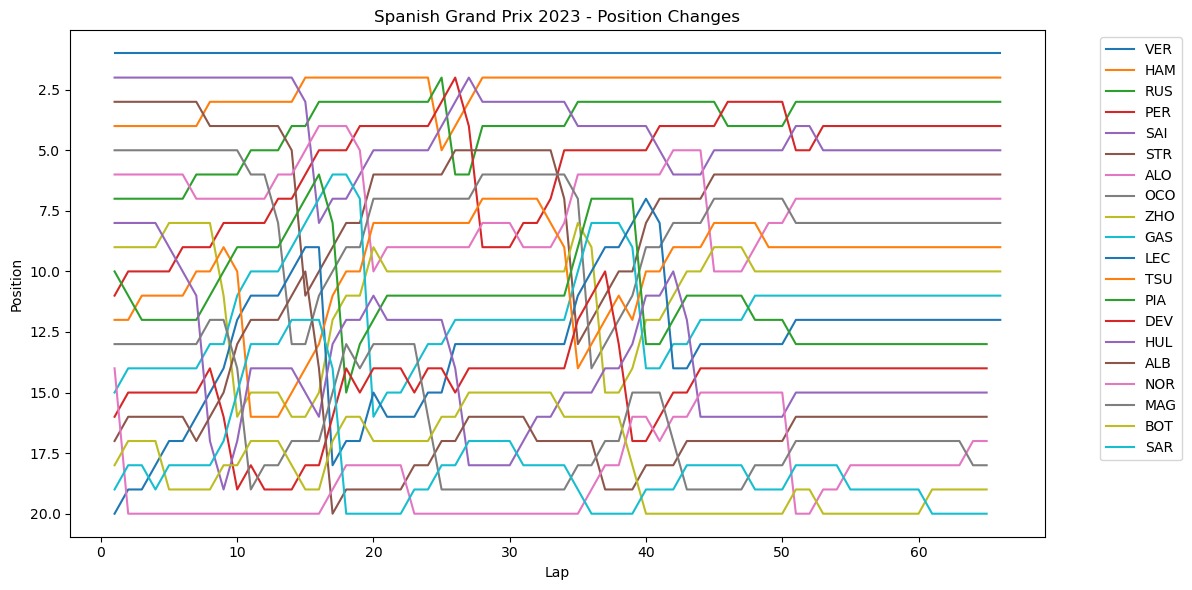

In [63]:
analysis.driver_position_chart()

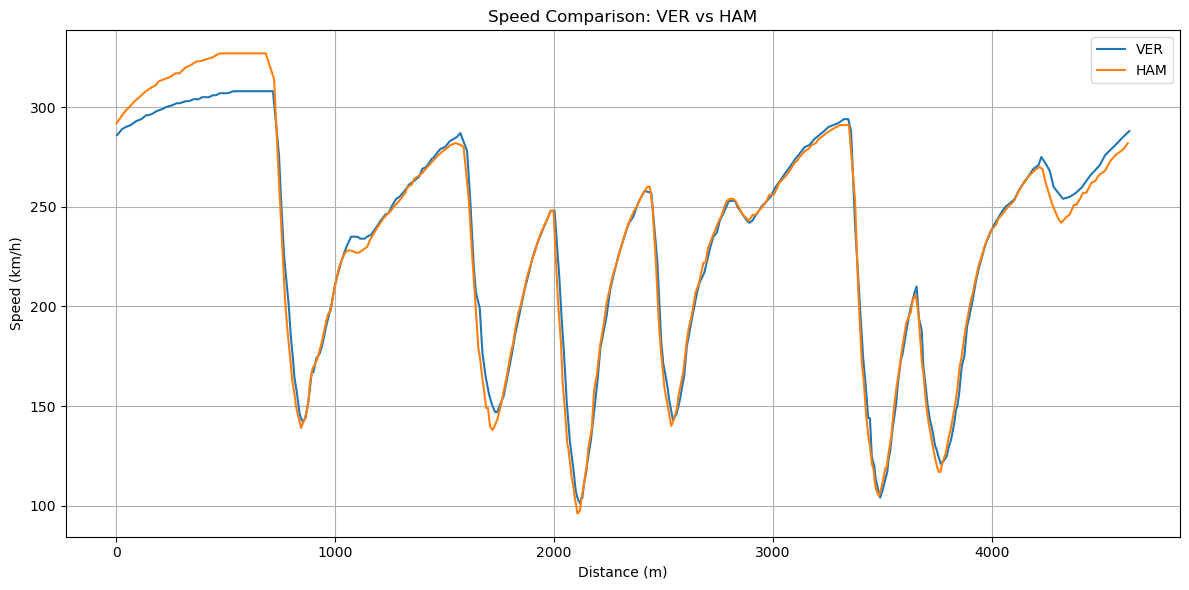

In [64]:
analysis.compare_speed_overlay("VER", "HAM")

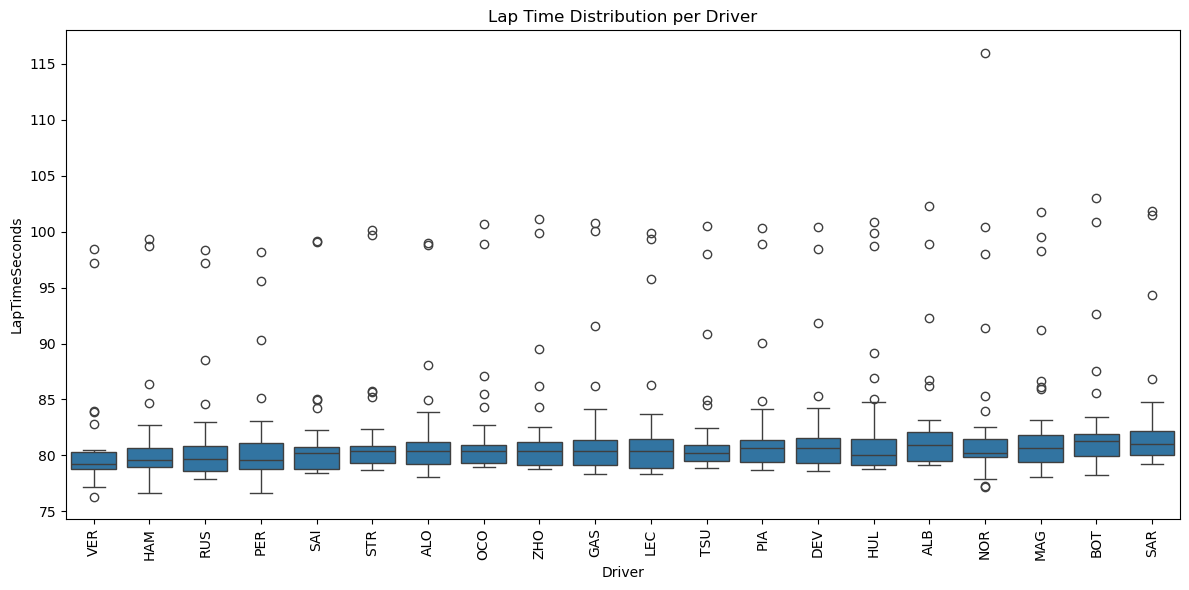

In [65]:
analysis.plot_lap_time_distribution()

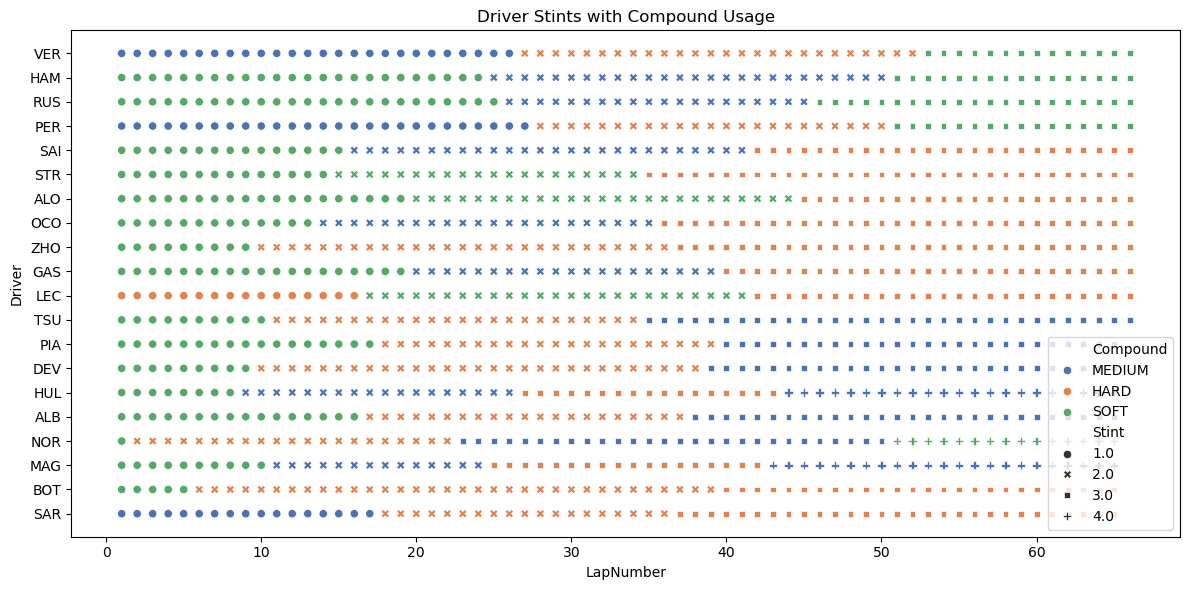

In [66]:
analysis.plot_driver_stints()

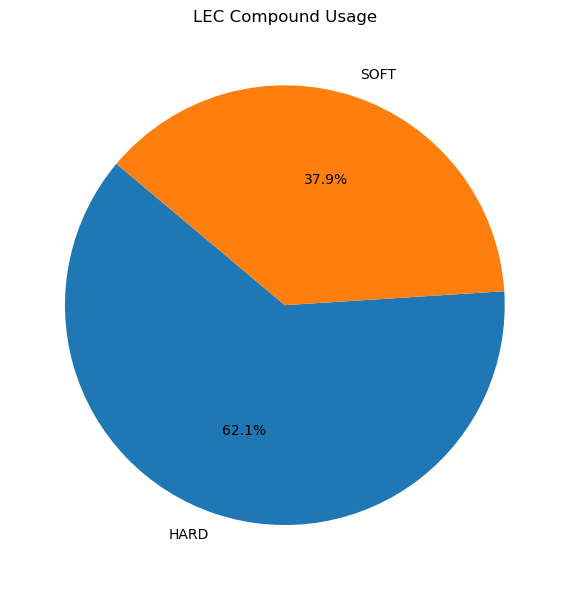

In [67]:
analysis.plot_compound_usage_pie("LEC")

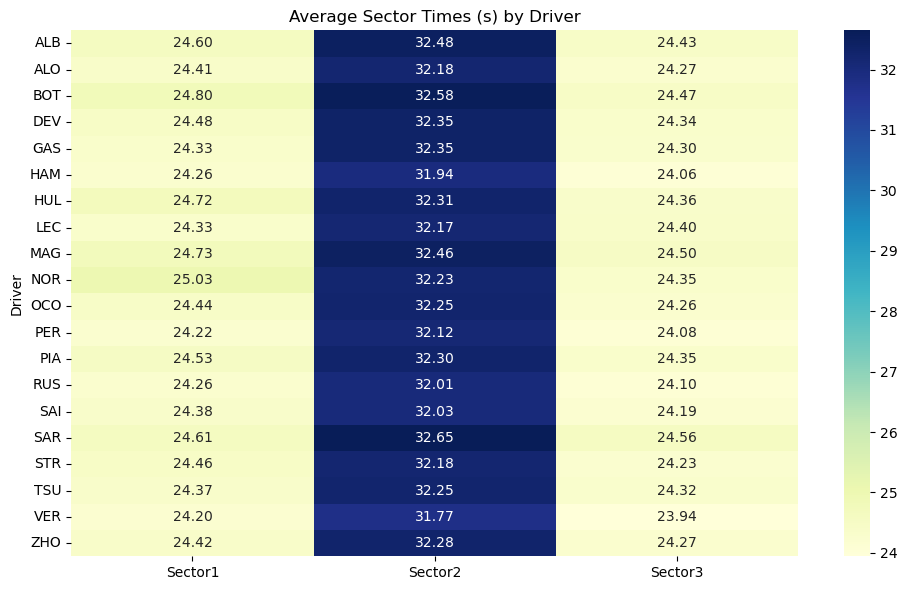

In [68]:
analysis.plot_sector_time_heatmap()

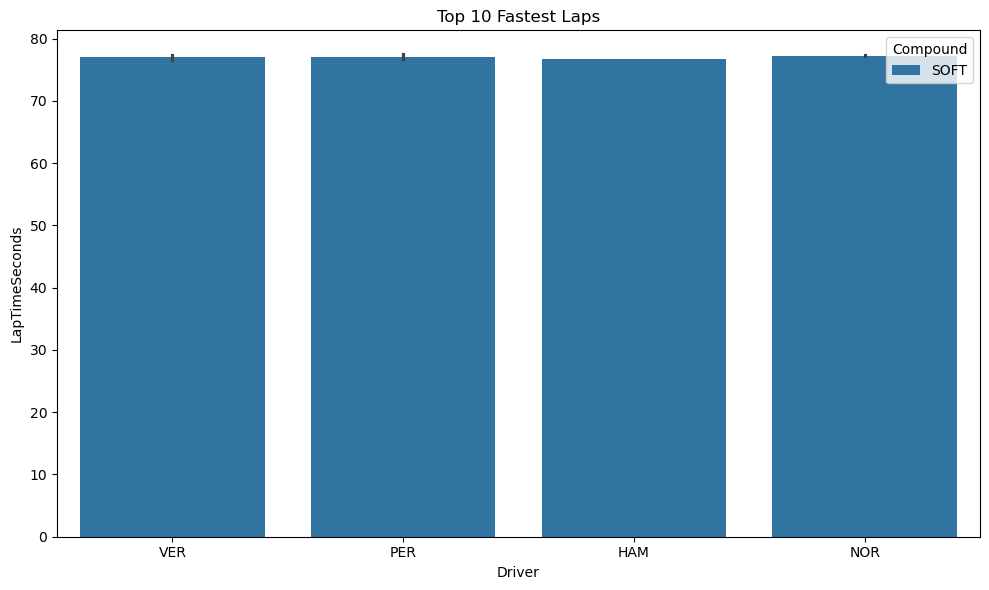

In [69]:
analysis.plot_top_n_fastest_laps(n=10) 

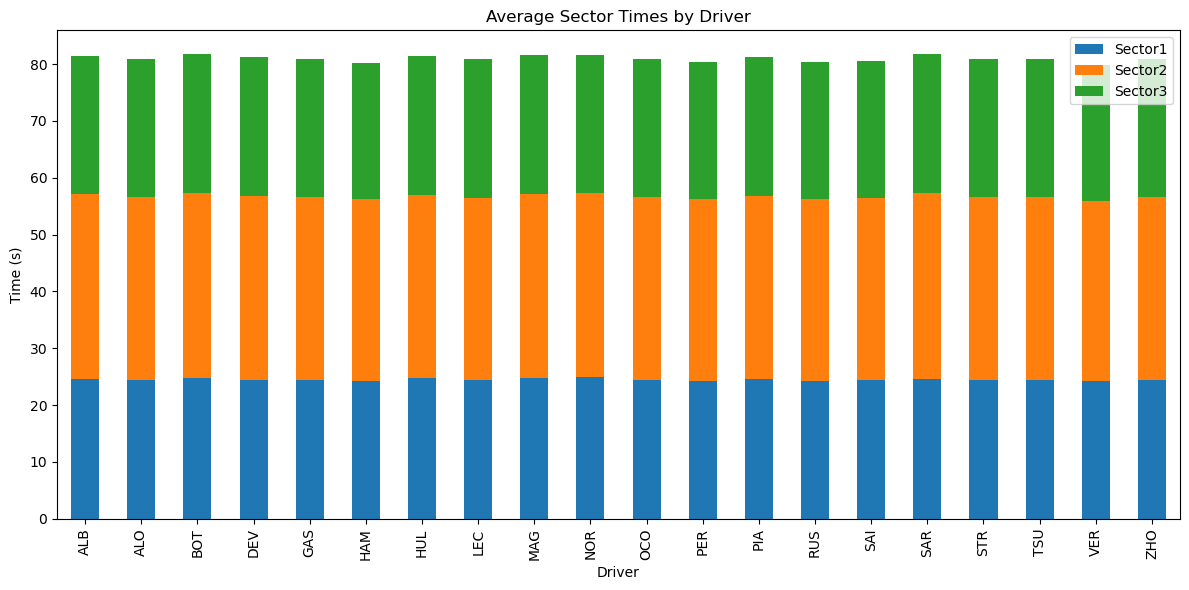

In [70]:
analysis.plot_avg_sector_times()

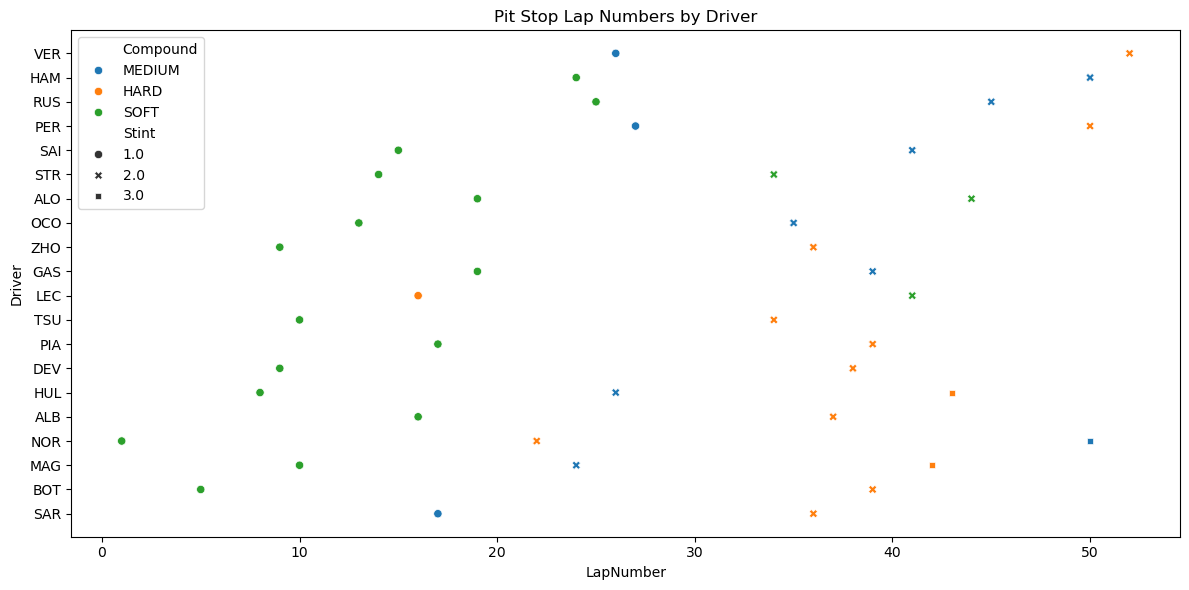

In [71]:
analysis.plot_pitstop_lap_scatter()

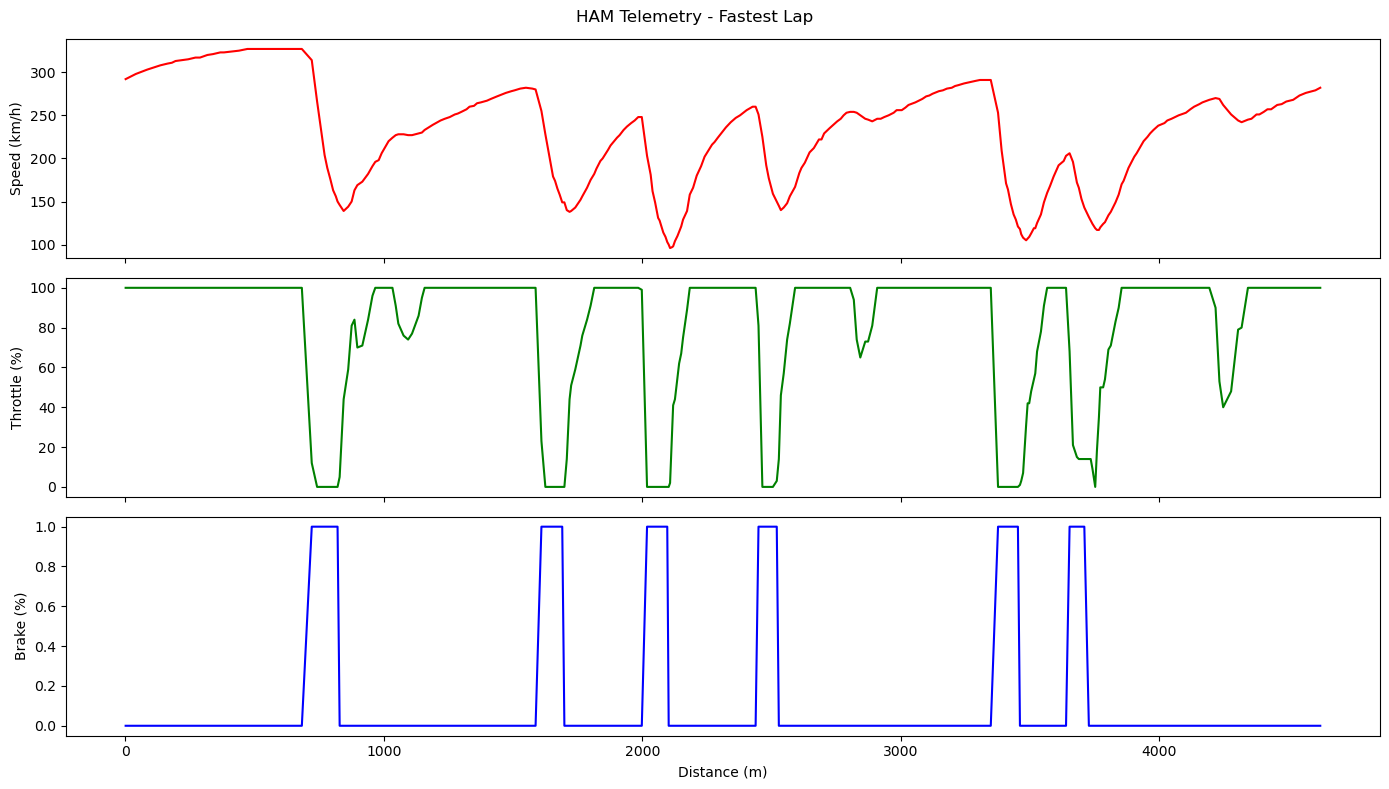

In [72]:
analysis.plot_driver_telemetry("HAM")